## Imports

In [1]:
from efaar_benchmarking.data_loading import *
from efaar_benchmarking.efaar import *
from efaar_benchmarking.constants import *
from efaar_benchmarking.benchmarking import *
import pandas as pd
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
from upsetplotly import UpSetPlotly

/Users/safiye.celik/.pyenv/versions/3.11.5/envs/eben/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/safiye.celik/.pyenv/versions/3.11.5/envs/eben/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/safiye.celik/.pyenv/versions/3.11.5/envs/eben/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check overlaps of the benchmark annotation sources (Supp Fig 1).

In [2]:
benchmark_sources = {}
for src in BENCHMARK_SOURCES:
    res = pd.read_csv(f'../efaar_benchmarking/benchmark_annotations/{src}.txt')
    res = res[res.entity1 != res.entity2]
    res['sorted_entities'] = res.apply(lambda row: tuple(sorted([row['entity1'], row['entity2']])), axis=1)
    benchmark_sources[src] = set(res.sorted_entities)

usp = UpSetPlotly(samples=list(benchmark_sources.values()), sample_names=list(benchmark_sources.keys()))
usp.plot(order_by='decreasing')

print(len(set().union(*list(benchmark_sources.values()))))

143252


## Check the number of expressed genes (for Table 1).

In [7]:
# PERISCOPE EXPRESSION COUNT
with open("data/periscope_loaded_metadata.pkl", 'rb') as outfile: ### TODO: the user does not know how to generate this file
    metadata = pickle.load(outfile)
all_genes = set(metadata[PERISCOPE_PERT_LABEL_COL])
hela_expr = pd.read_csv('data/hela_expression.csv')
hela_expr.columns = ['gene', 'tpm']
hela_expr.gene = hela_expr.gene.apply(lambda x: x.split(' ')[0])
hela_exp_genes = all_genes.intersection(hela_expr[hela_expr.tpm != 0].gene)
hela_unexp_genes = all_genes.intersection(hela_expr[hela_expr.tpm == 0].gene)
print('PERISCOPE', len(hela_exp_genes), len(hela_unexp_genes), len(all_genes))

# JUMP EXPRESSION COUNT
features_orig, metadata = load_cpg16_crispr()
features, metadata = filter_cell_profiler_features(features_orig, metadata)
all_genes = set(metadata[JUMP_PERT_LABEL_COL])
u2os_expr = pd.read_csv('data/u2os_expression.csv', index_col=0)
u2os_expr = u2os_expr.groupby('gene').zfpkm.agg('median').reset_index()
u2os_exp_genes = all_genes.intersection(u2os_expr[u2os_expr.zfpkm >= -3].gene)
u2os_unexp_genes = all_genes.intersection(u2os_expr[u2os_expr.zfpkm < -3].gene)
print('JUMP', len(u2os_exp_genes), len(u2os_unexp_genes), len(all_genes))

PERISCOPE 15490 3665 20422
JUMP 6389 1516 7977


## Check unfiltered cell count features in JUMP (Supp Fig 2)

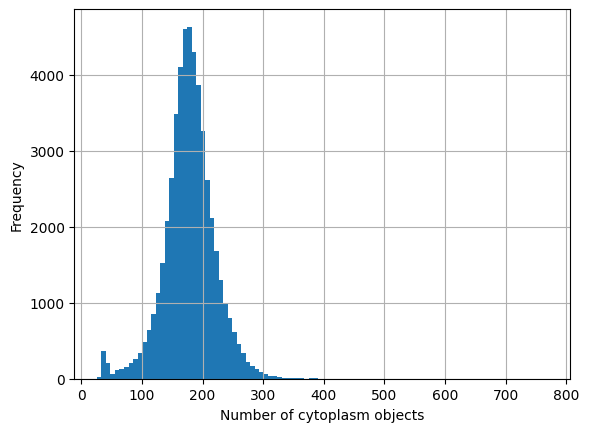

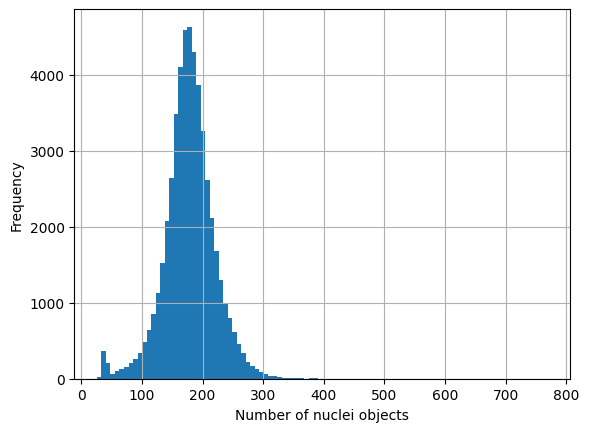

In [8]:
features_orig['Cytoplasm_Number_Object_Number'].hist(bins=100)
plt.xlabel('Number of cytoplasm objects')
plt.ylabel('Frequency')
plt.show()

features_orig['Nuclei_Number_Object_Number'].hist(bins=100)
plt.xlabel('Number of nuclei objects')
plt.ylabel('Frequency')
plt.show()

## Check overlaps of identified protein complexes across the four perturbative maps (Section 4.3.4 & Fig 2).

171 clusters are used from the benchmark source CORUM
171 clusters are used from the benchmark source CORUM
171 clusters are used from the benchmark source CORUM


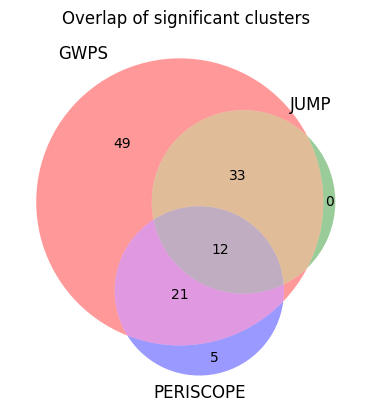

In [4]:
# These pickle files only include expressed genes.
with open('data/jump_aggr_tvn128_map.pkl', 'rb') as outfile: ### TODO: the user does not know how to generate this file
    jump_map_data = pickle.load(outfile)

with open('data/periscope_aggr_tvn128_map.pkl', 'rb') as outfile: ### TODO: the user does not know how to generate this file
    periscope_map_data = pickle.load(outfile)

with open('data/replogle_aggr_tvn128_map.pkl', 'rb') as outfile: ### TODO: the user does not know how to generate this file
    gwps_map_data = pickle.load(outfile)

len(jump_map_data.metadata[JUMP_PERT_LABEL_COL].unique()), len(periscope_map_data.metadata[PERISCOPE_PERT_LABEL_COL].unique()), len(gwps_map_data.metadata[GWPS_PERT_LABEL_COL].unique())

jump_metrics = cluster_benchmark(jump_map_data, pert_col=JUMP_PERT_LABEL_COL)
periscope_metrics = cluster_benchmark(periscope_map_data, pert_col=PERISCOPE_PERT_LABEL_COL)
gwps_metrics = cluster_benchmark(gwps_map_data, pert_col=GWPS_PERT_LABEL_COL)

thr = .01
metdict = {'GWPS': gwps_metrics, 'JUMP': jump_metrics, 'PERISCOPE': periscope_metrics}
sigs = {}
for k, df in metdict.items():
    sigs[k] = set(df[df.ks_pval <= thr].cluster)

for k, s in sigs.items():
    pd.Series(list(s)).to_csv(f'data/{k}_significant_clusters.csv', index=False)

venn3(list(sigs.values()), list(sigs.keys()))
plt.title('Overlap of significant clusters')
plt.show()


## Confirm the identified relationships of C18orf21 and C1orf131 in GWPS (Section 4.3.5)

In [12]:
print('Top relationships of C18orf21 in GWPS:')
print(compute_top_similars(gwps_map_data, GWPS_PERT_LABEL_COL, 'C18orf21', topx=75))
print('Top relationships of C1orf131 in GWPS:')
print(compute_top_similars(gwps_map_data, GWPS_PERT_LABEL_COL, 'C1orf131'))

Top relationships of C18orf21 in GWPS:
     pert  cosine_sim
0    RRP9    0.850833
1    WDR3    0.847261
2   DDX21    0.846584
3    POP5    0.846203
4   DHX37    0.844454
..    ...         ...
70  NEPRO    0.743703
71  BUD23    0.743554
72   PNO1    0.740501
73   MCEE    0.738819
74  GNPAT    0.738751

[75 rows x 2 columns]
Top relationships of C1orf131 in GWPS:
      pert  cosine_sim
0     KRR1    0.962824
1     IMP4    0.956064
2     AATF    0.954428
3    RIOK1    0.950252
4     FCF1    0.946894
5    RRP12    0.944801
6    RIOK2    0.942282
7  DNTTIP2    0.942139
8     NOL6    0.941582
9    UTP20    0.940173
